In [104]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pickle

import matplotlib as mpl
mpl.rc('image', cmap='plasma')


nDivisionsXY = 336
sLength = 83.5
ENERGY_PLOT_CUT = 0.90

ENERGY = 25 # GeV
# ENERGY = 1 # GeV
SIM_OUT_DIRS = f"Sim_maps/{ENERGY}GeV"

if ENERGY == 25:
    number_of_events = 1000 # use for 25 GeV
elif ENERGY == 1:
    number_of_events = 3000 # use for 1 GeV


# MAP_NAME = "MAPCorner0"
# MAP_NAME = "MAPCorner1"
MAP_NAME = "MAPCorner2"
wights_map_1cell = np.loadtxt("maps/" + MAP_NAME + ".txt")


# this not suppose to change final result,
# but make visualsation of maps the same as
# in Herve's presentation
wights_map_1cell = np.transpose(wights_map_1cell)

print("Energy =", ENERGY, "GeV")
print("Map name is", MAP_NAME)

Energy = 25 GeV
Map name is MAPCorner2


In [105]:
def calcEventsMesh(baseDir:str, xhit, yhit):


    try:
        with open(baseDir+f"/gamma_{ENERGY}GeV_{xhit},{yhit}.pkl", "rb") as pickle_f:

            mesh = pickle.load(pickle_f)

    except FileNotFoundError:

        mesh = np.zeros((number_of_events, nDivisionsXY, nDivisionsXY))

        for enNum in range(number_of_events):

            with open(baseDir+f"/{xhit},{yhit}/evnt_{enNum}_gamma_{ENERGY}GeV_{xhit},{yhit}.txt") as fileEdep:

                fileEdep.readline() # skip 3 firts lines
                fileEdep.readline()
                fileEdep.readline()

                for line in fileEdep:
                    lineSplit = line.split(",")

                    ix = int(lineSplit[0])
                    iy = int(lineSplit[1])

                    eDep = float(lineSplit[3])

                    mesh[enNum, ix, iy] += eDep

        pickle_f_name = baseDir+f"/gamma_{ENERGY}GeV_{xhit},{yhit}.pkl"
        print("Creating new pickle file", pickle_f_name)

        with open(pickle_f_name, "wb") as pickle_f:

            pickle.dump(mesh, pickle_f)

    return mesh

In [106]:
meshs_dict = {}

for i in range(4):
    for j in range(0,i+1):

        key = f"X={i},Y={j}"

        print(key)

        meshs_dict[key] = calcEventsMesh(SIM_OUT_DIRS, i,j)


        # make zero deposited energy in the position of fibers

        idxs1 = np.arange(6,336, 14)
        idxs2 = np.arange(7,336, 14)
        idxs = np.concatenate([idxs1, idxs2], axis=0)

        idxs_x, idxs_y = np.meshgrid(idxs, idxs)

        idxs_x = idxs_x.flatten()
        idxs_y = idxs_y.flatten()

        meshs_dict[key][:,idxs_x,idxs_y] = 0

        # croup bins an the edghe and combine four bins into one

        meshs_dict[key] = meshs_dict[key][:,1:-1,1:-1]

        meshs_dict[key] = meshs_dict[key][:,0::2, 0::2] + meshs_dict[key][:,1::2, 0::2] +\
                          meshs_dict[key][:,0::2, 1::2] + meshs_dict[key][:,1::2, 1::2]
                

X=0,Y=0
X=1,Y=0
X=1,Y=1
X=2,Y=0
X=2,Y=1
X=2,Y=2
X=3,Y=0
X=3,Y=1
X=3,Y=2
X=3,Y=3


In [107]:
# %matplotlib widget

# mesh = meshs_dict["X=3,Y=2"]

# mesh = np.mean(mesh, axis=0)

# eDepMean = np.sum(mesh)

# #################################
# ## eDep plots
# #################################
# plt.figure(figsize=(2*6.4, 2*4.8))
# plt.imshow(np.transpose(mesh)[::-1,:], extent=(-sLength, sLength, -sLength, sLength), norm=colors.LogNorm(vmin=1e-3))
# cbar = plt.colorbar()
# cbar.ax.set_ylabel("Deposited Energy [MeV]")
# plt.xlabel("x [mm]")
# plt.ylabel("y [mm]")
# ax = plt.gca()
# ax.text(0.55, 0.01, "dx = dy = {:.2f} mm".format(sLength*2/nDivisionsXY), transform=ax.transAxes, color="orange")
# ax.text(0.05, 0.01, "Mean (over events)\ndeposited energy\nis {:.2f} MeV".format(eDepMean),
#                 transform=ax.transAxes, color="orange")

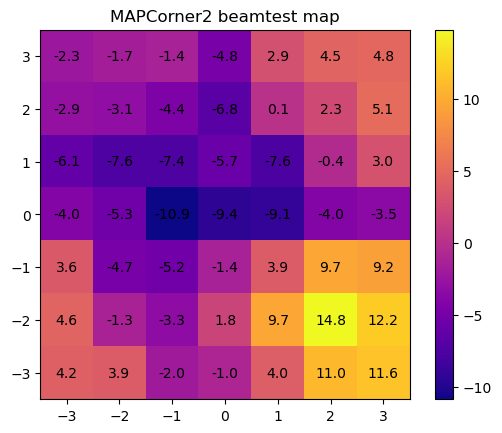

In [108]:
plt.figure(figsize=(6.4, 4.8))
plt.imshow(np.transpose(wights_map_1cell)[::-1,:], extent=(-3.5, 3.5, -3.5, 3.5))

for (j,i),label in np.ndenumerate(np.transpose(wights_map_1cell)[::-1,:]):
    plt.gca().text(i-3,3-j,"{:.1f}".format(label),ha='center',va='center')

cbar = plt.colorbar()
plt.title(MAP_NAME+" beamtest map")

plt.savefig("plots/Efficiency_map_muons.png")

# plt.clim(-20, 20)

In [109]:
nBins = nDivisionsXY//2-1

def elem_function(i, j):

    i = np.mod(i.astype(int)+4,7)
    j = np.mod(j.astype(int)+4,7)

    result = np.array(wights_map_1cell)[i,j]/100 + 1

    return result

wights_map = np.fromfunction(elem_function, (nBins,nBins) )

In [110]:
# plt.figure(figsize=(2*6.4, 2*4.8))
# plt.imshow(np.transpose(wights_map)[::-1,:], extent=(-sLength, sLength, -sLength, sLength))

# cbar = plt.colorbar()
# plt.clim(0.8, 1.2)

In [111]:
# modulated = mesh*wights_map

# plt.figure(figsize=(2*6.4, 2*4.8))
# plt.imshow(np.transpose(modulated)[::-1,:], extent=(-sLength, sLength, -sLength, sLength), norm=colors.LogNorm(vmin=1e-3))
# cbar = plt.colorbar()
# cbar.ax.set_ylabel("Deposited Energy [MeV]")
# plt.xlabel("x [mm]")
# plt.ylabel("y [mm]")

In [112]:
from scipy.optimize import curve_fit 

def dispHistAndGauss(ax, data):

    # n_bins = int(np.sqrt(data.size))
    n_bins = 50
    bin_size = (np.max(data) - np.min(data))/n_bins

    histCounts, edges, _ = ax.hist(data, bins = n_bins)
    binCenters = (edges[1:] + edges[:-1])/2

    gaussFunc = lambda x, A, mu, sig: A*np.exp(-(x-mu)**2/sig**2/2)
    mu = np.mean(data)
    sig = np.std(data, ddof=1)
    A = data.size/(np.sqrt(2*np.pi)*sig)*bin_size
    p0 = (A, mu, sig)

    (A, mu, sig), _ = curve_fit(gaussFunc, binCenters, histCounts , p0=p0)

    x_gauss = np.linspace(np.min(data), np.max(data), 4*n_bins)
    y_gauss = gaussFunc(x_gauss, A, mu, sig)

    ax.plot(x_gauss, y_gauss, "r", label="$\sigma={:.2e}$\n$\mu={:.2e}$".format(sig, mu))
    ax.set_xlabel("$(\\tilde{E}_{ecs} - E_{ecs})/E_0$")
    ax.legend()

/tmp/ipykernel_99806/426957209.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2) = plt.subplots(1,2,figsize=(2*6.4, 1*4.8))


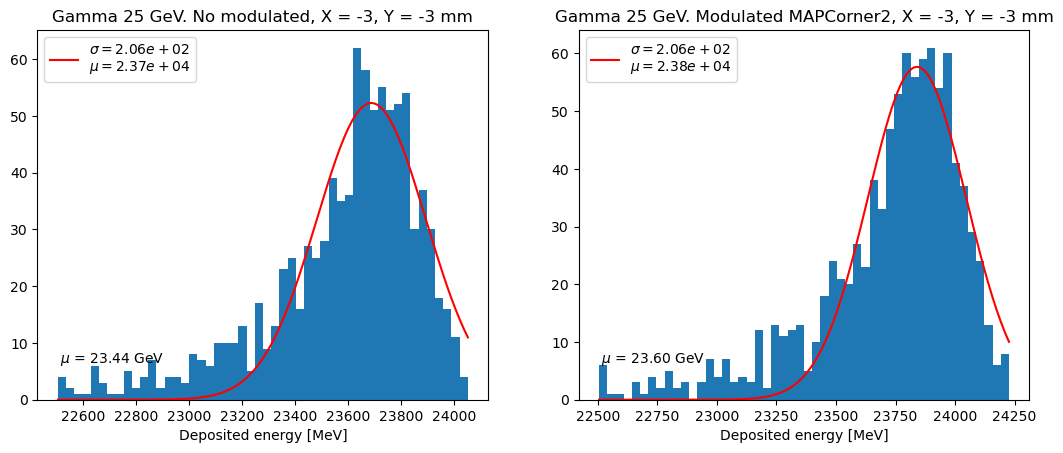

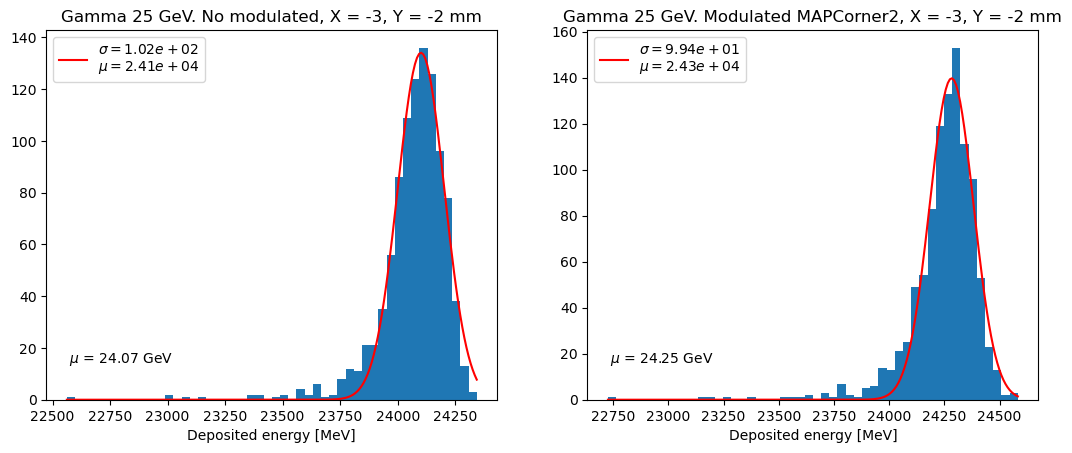

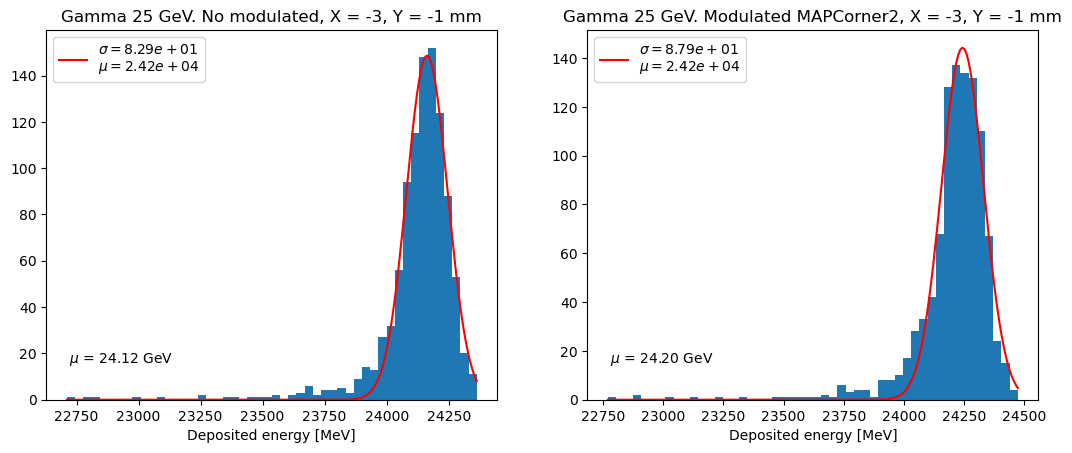

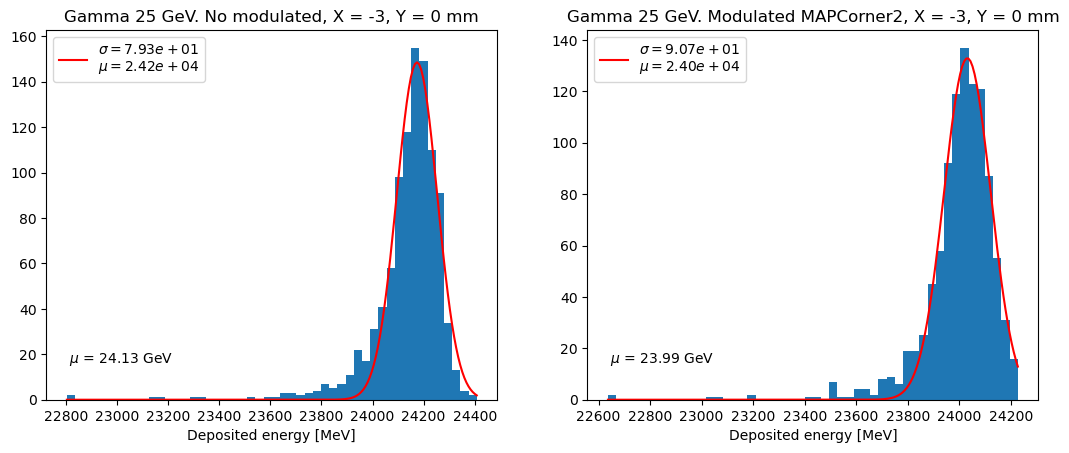

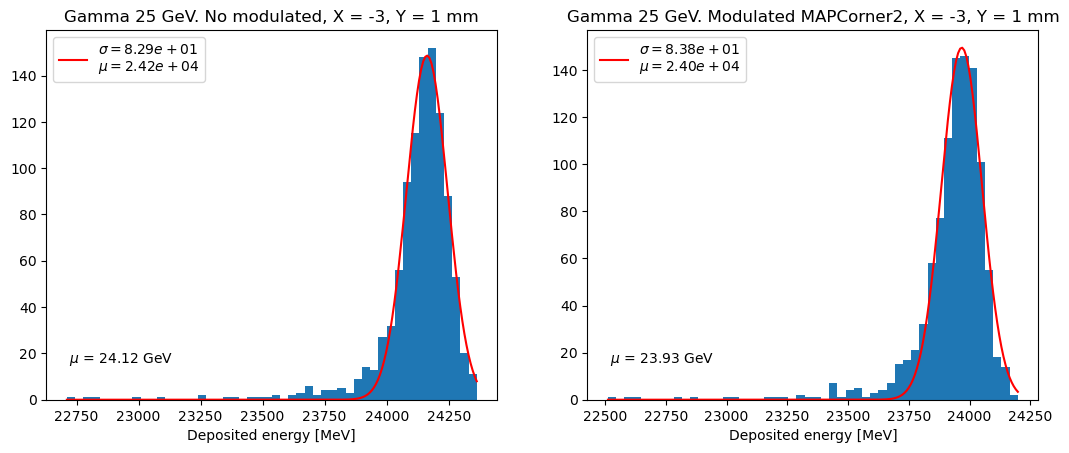

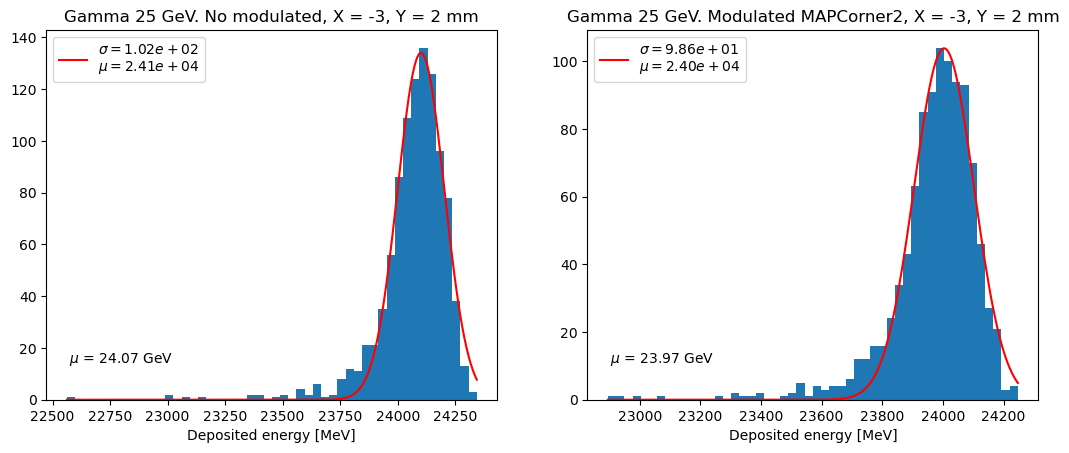

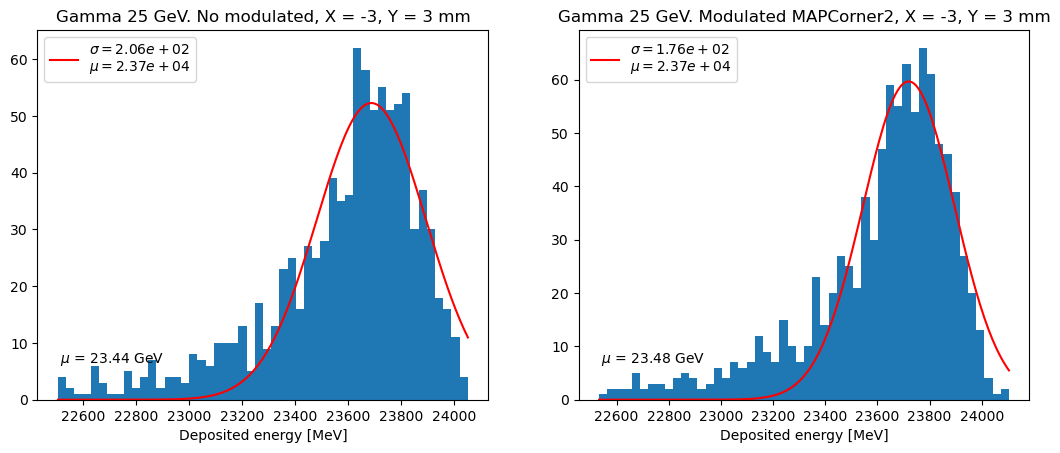

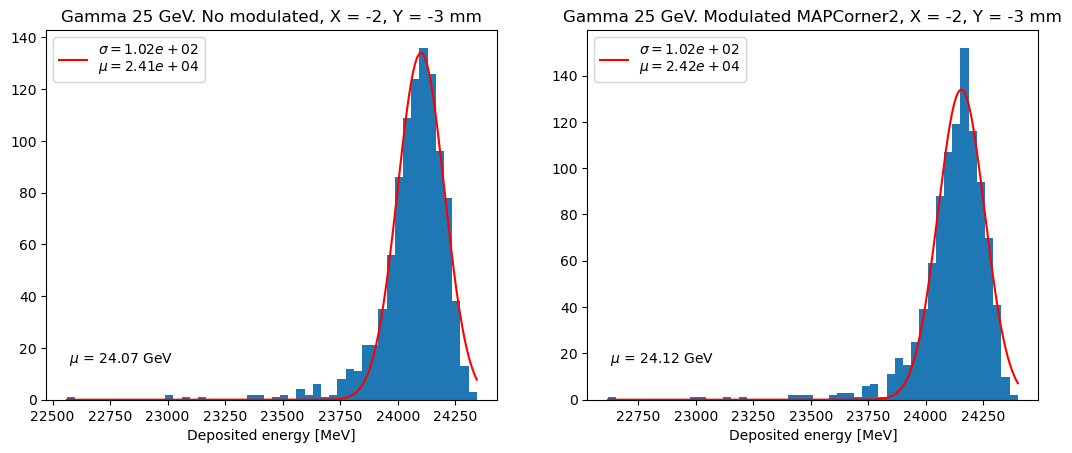

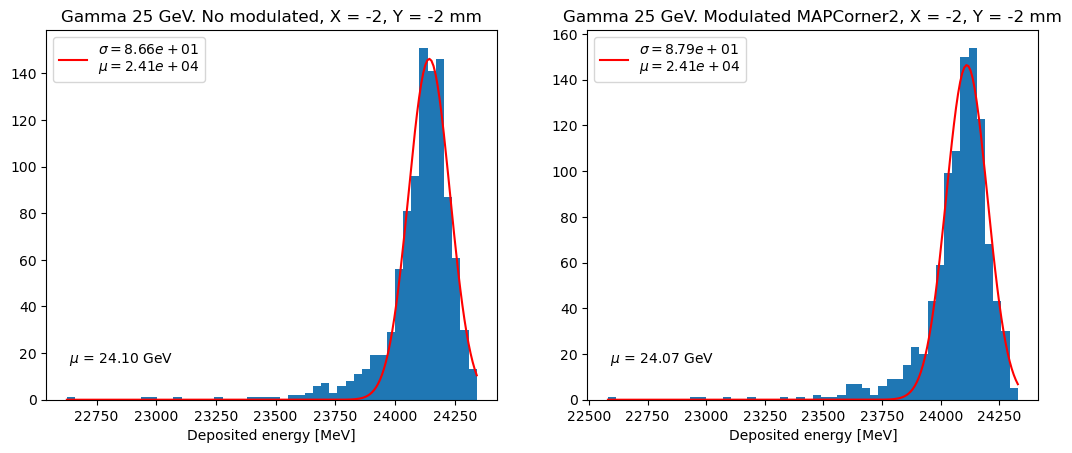

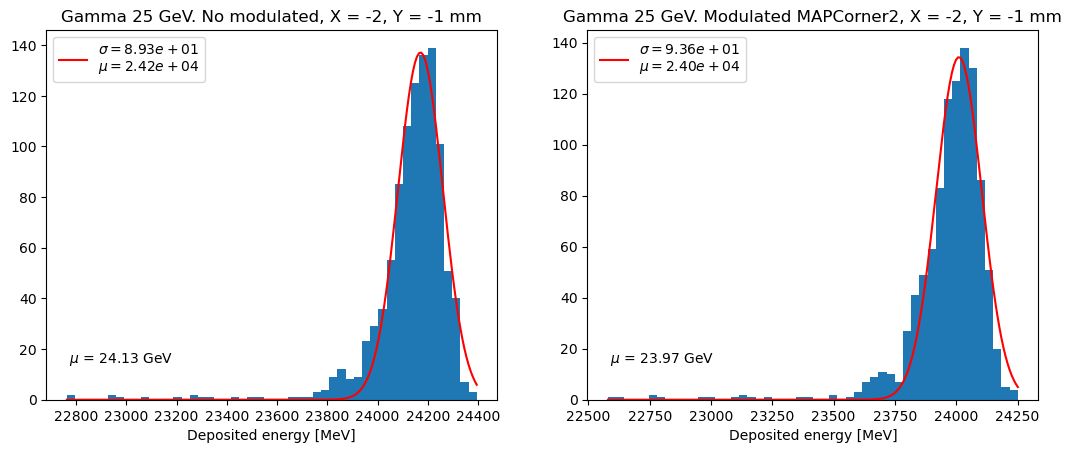

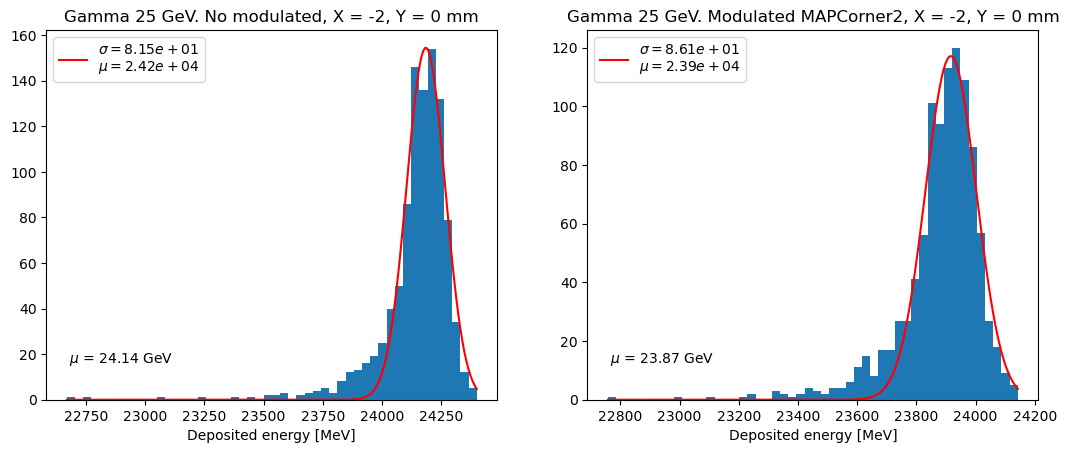

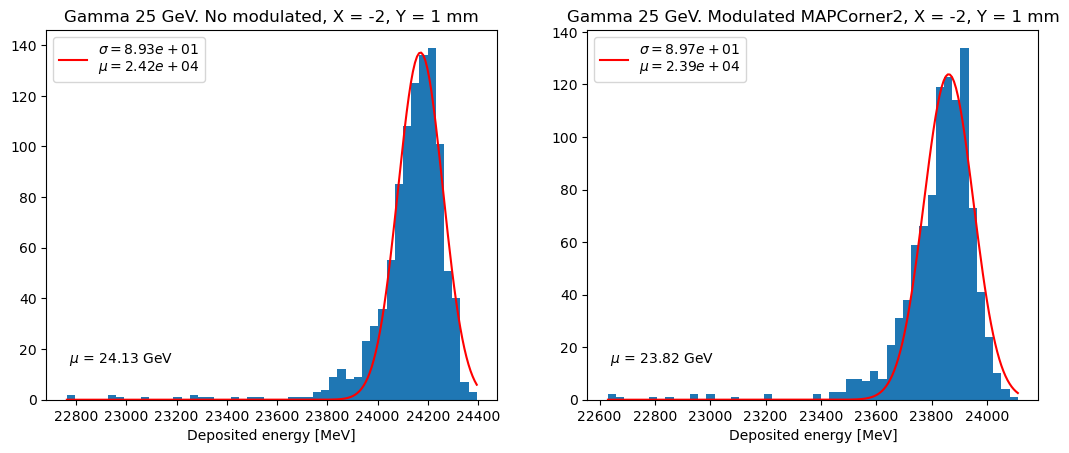

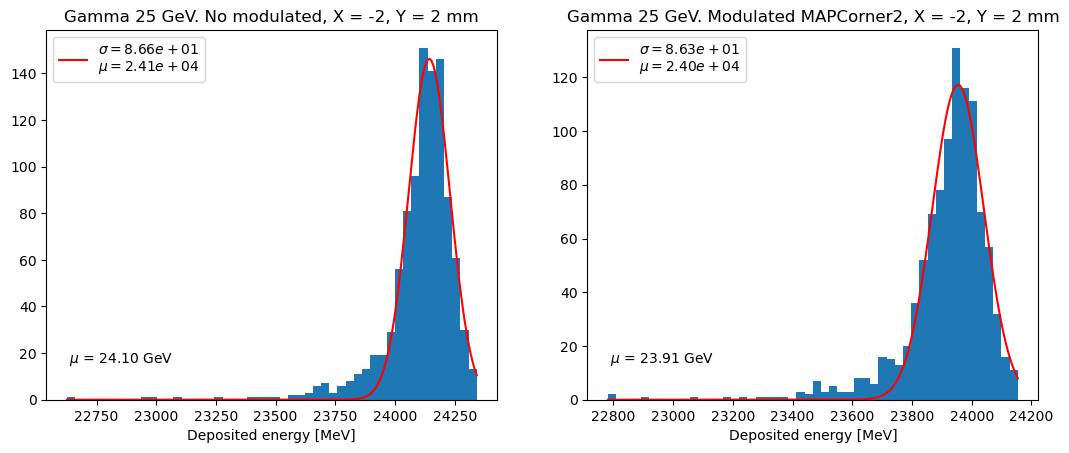

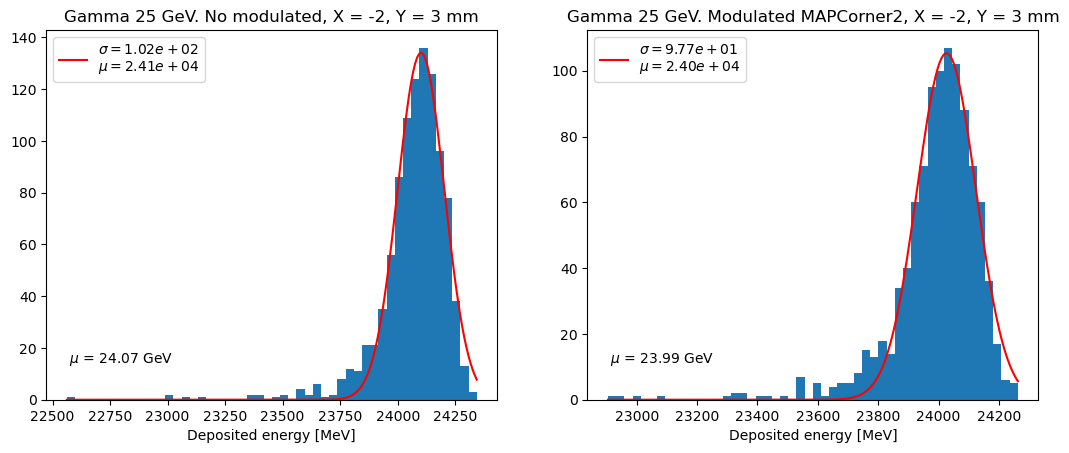

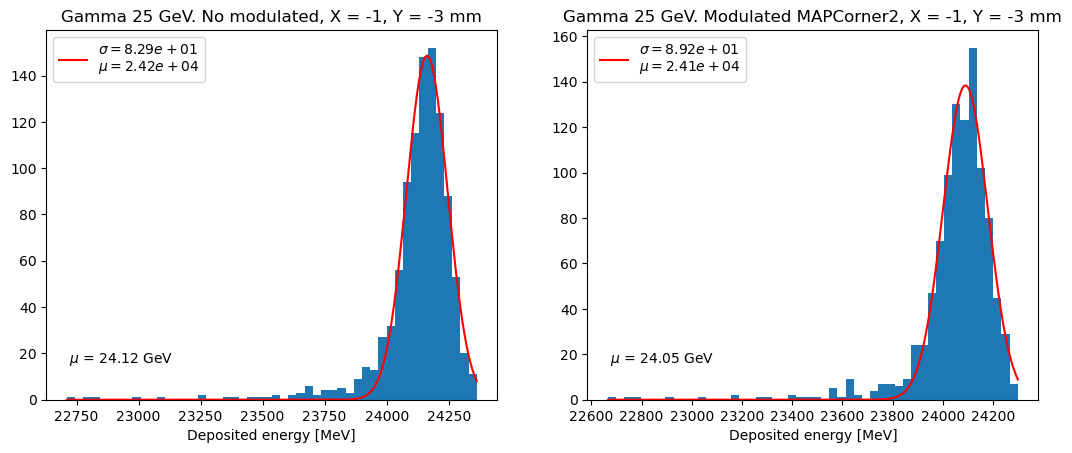

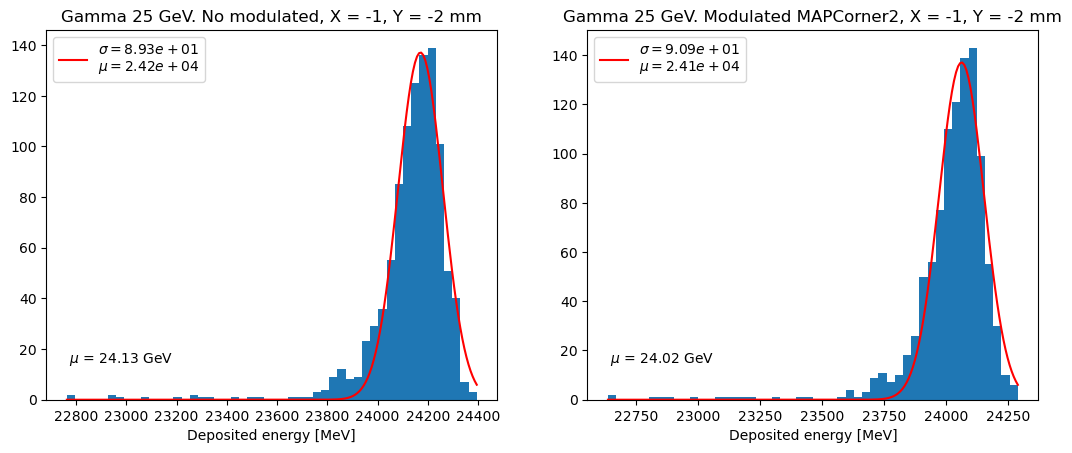

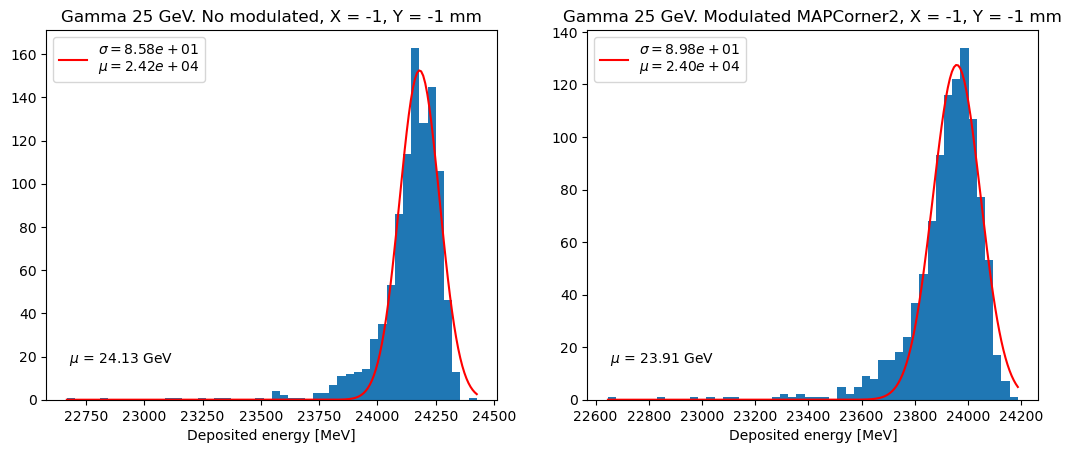

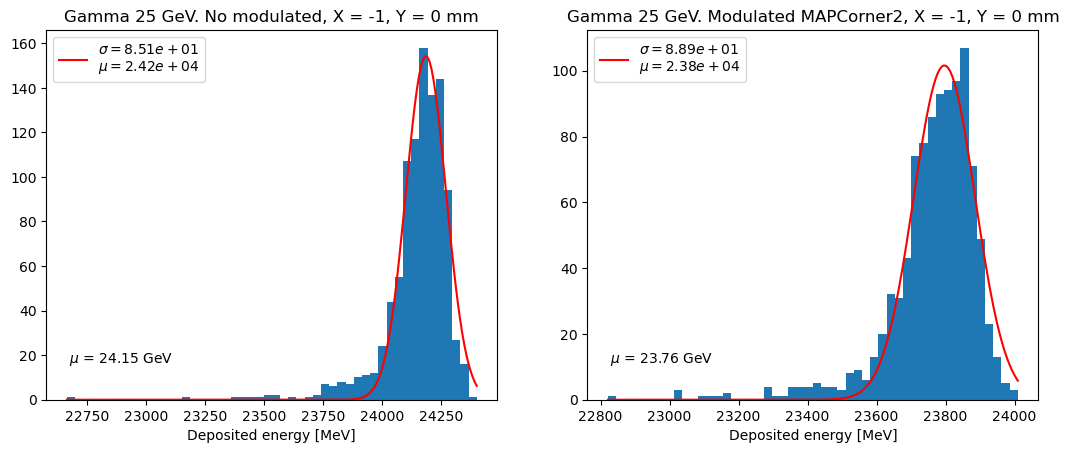

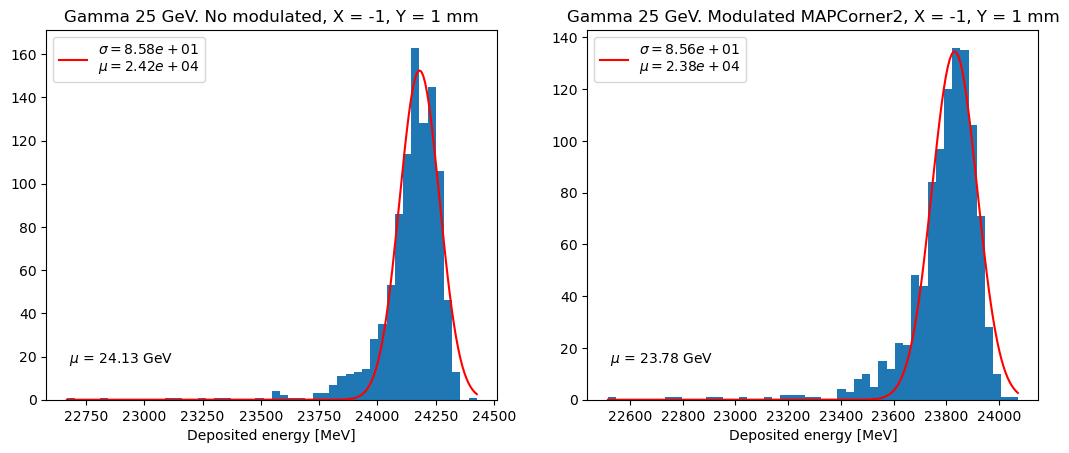

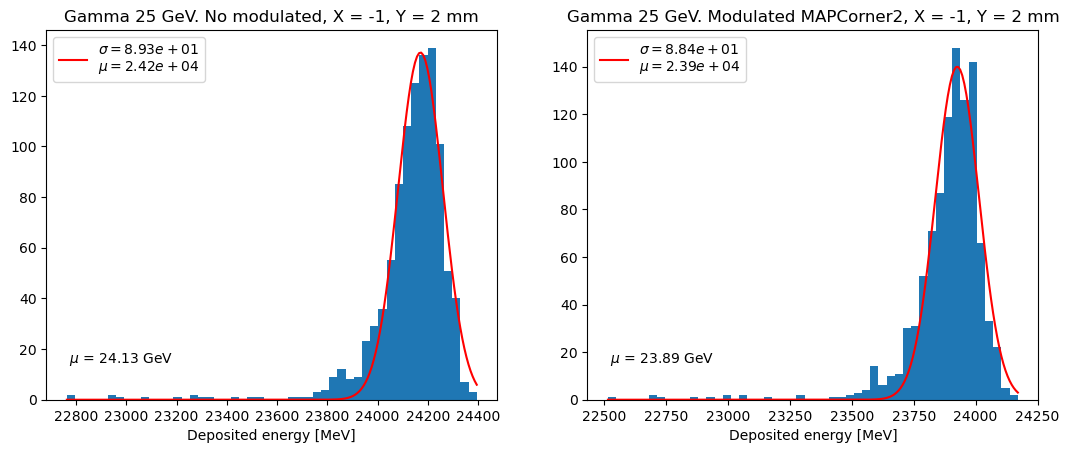

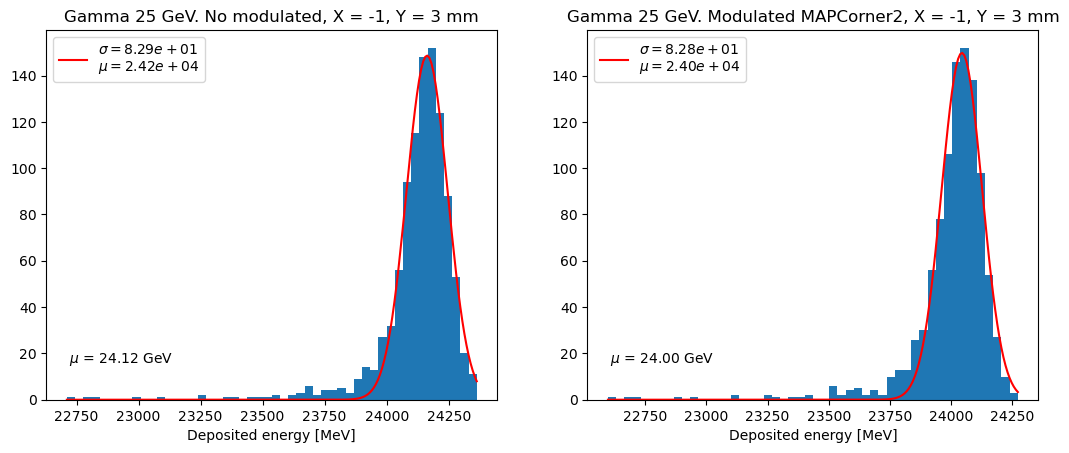

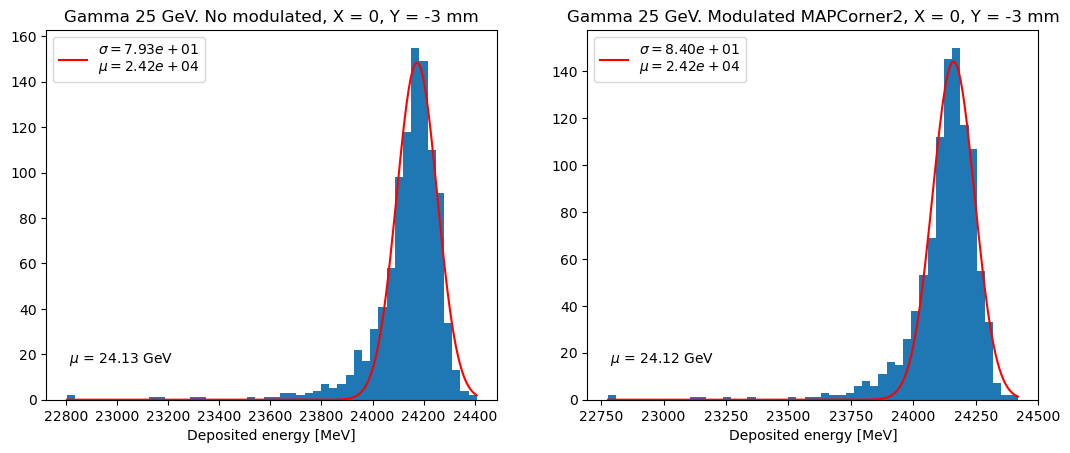

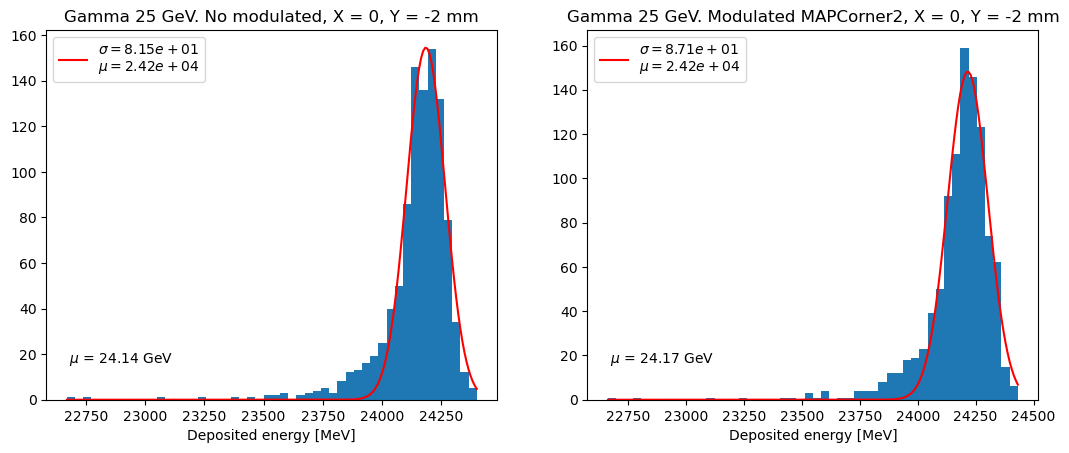

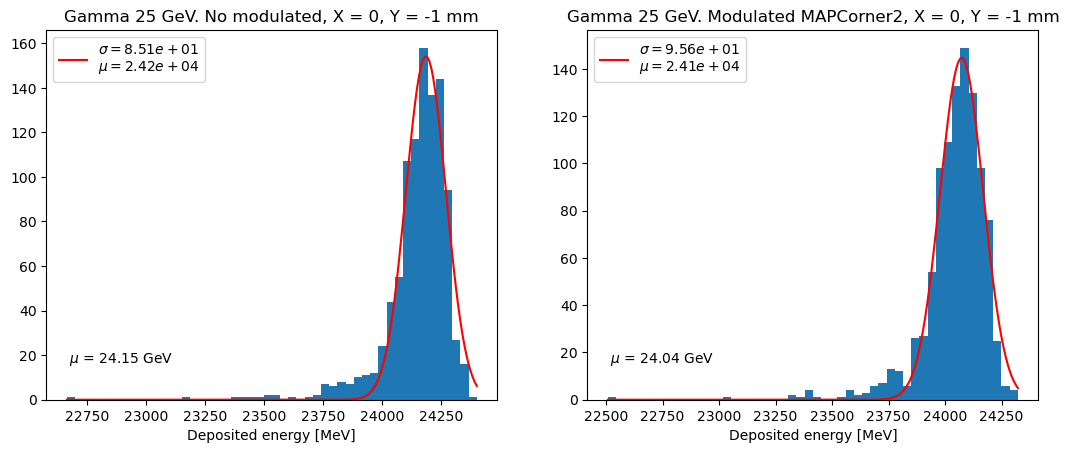

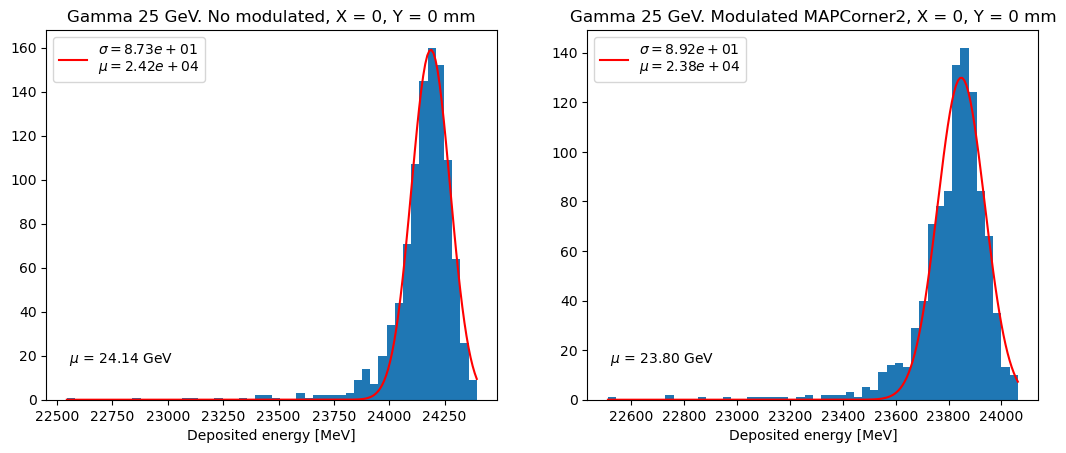

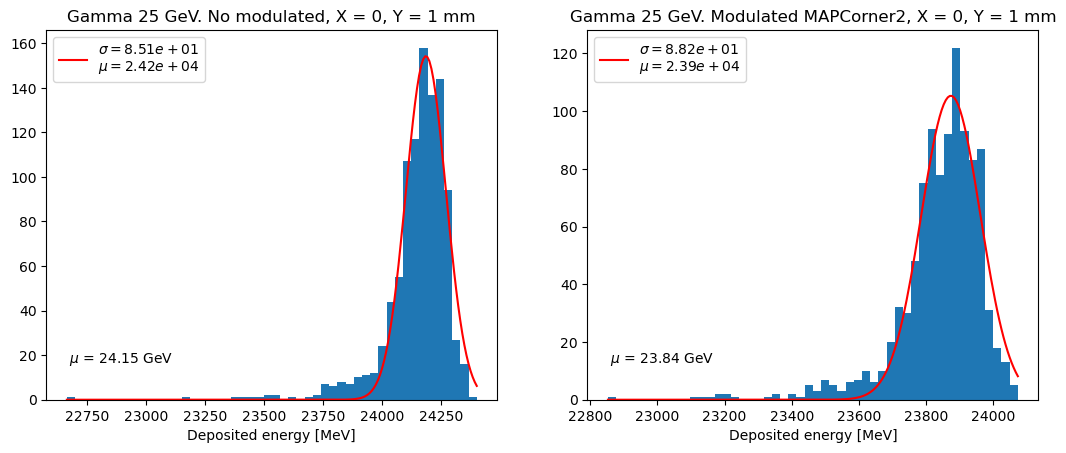

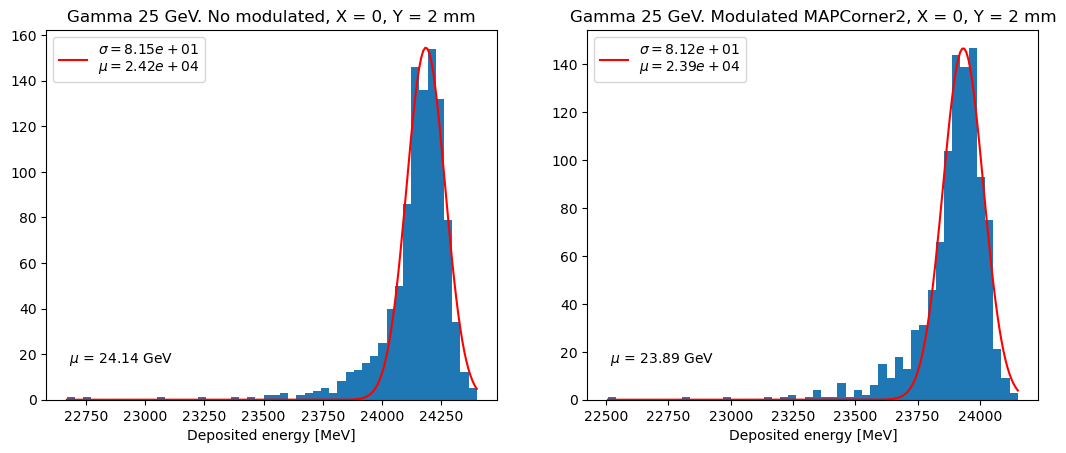

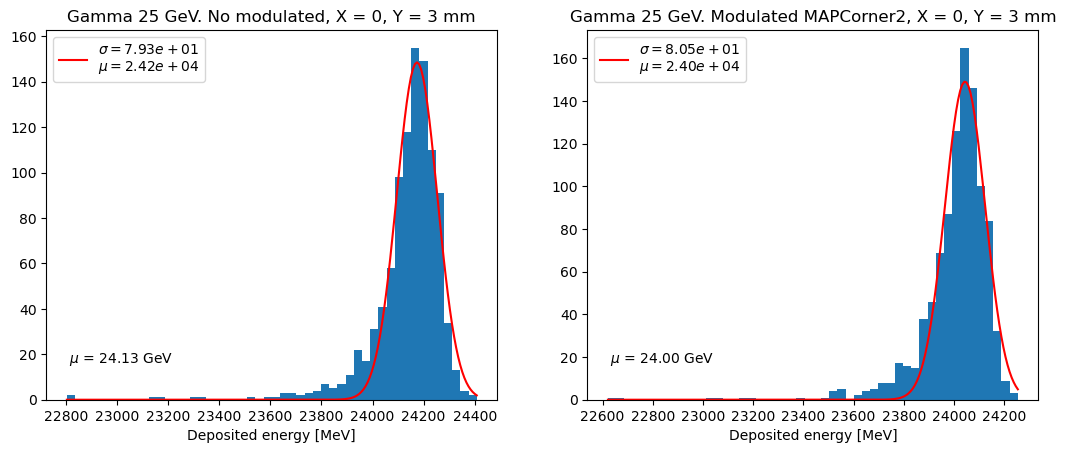

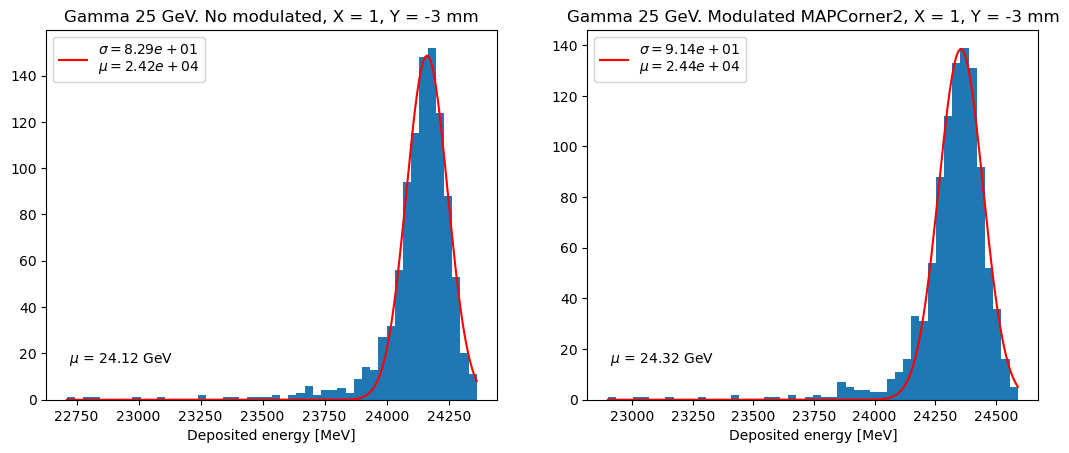

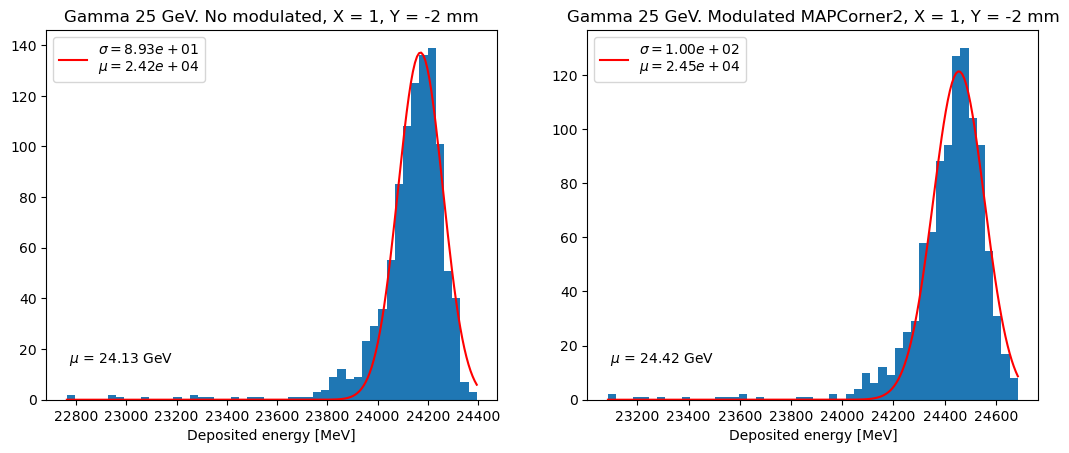

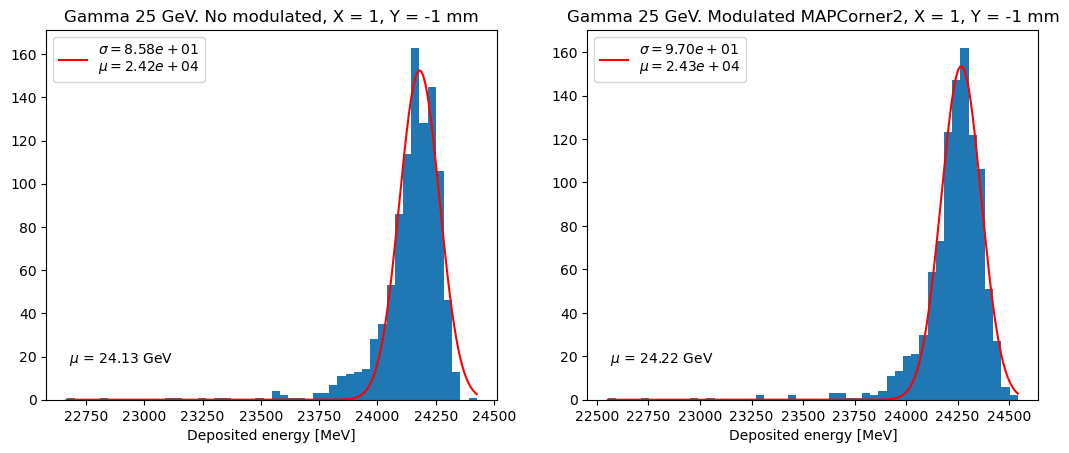

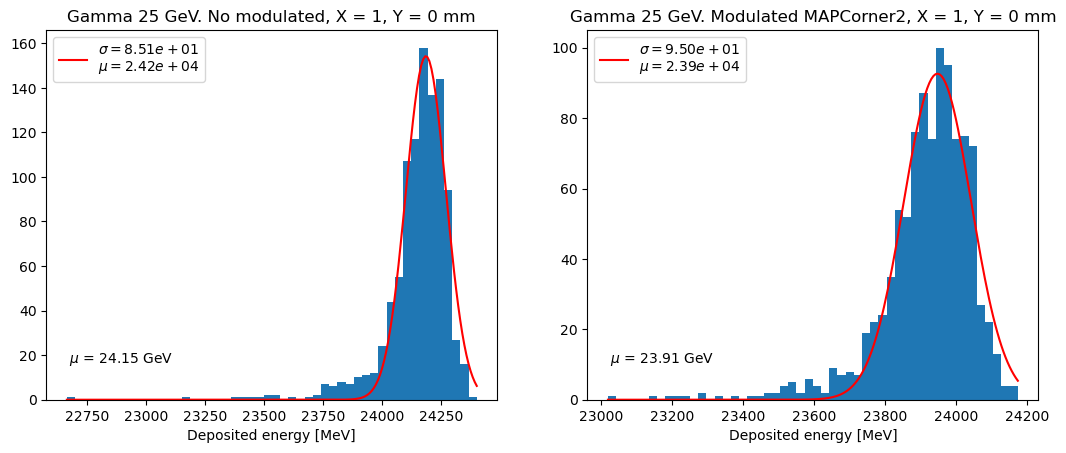

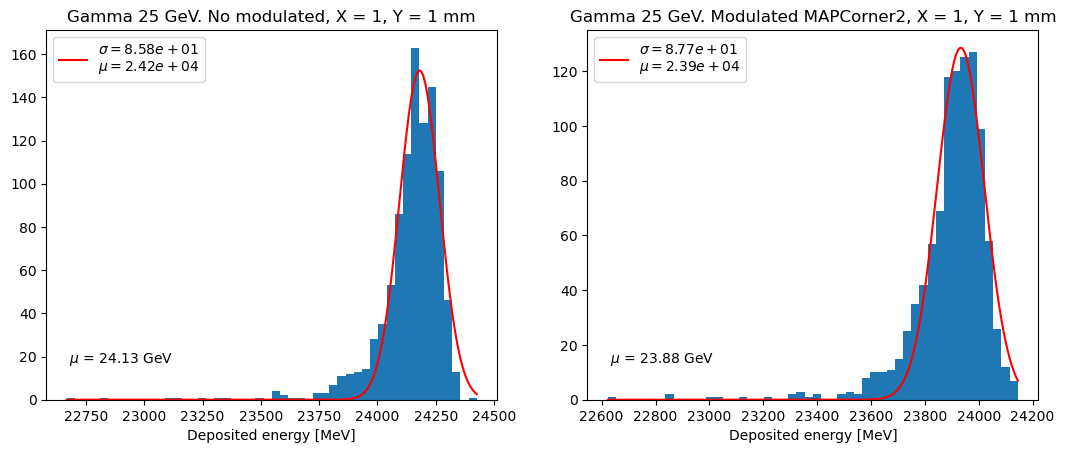

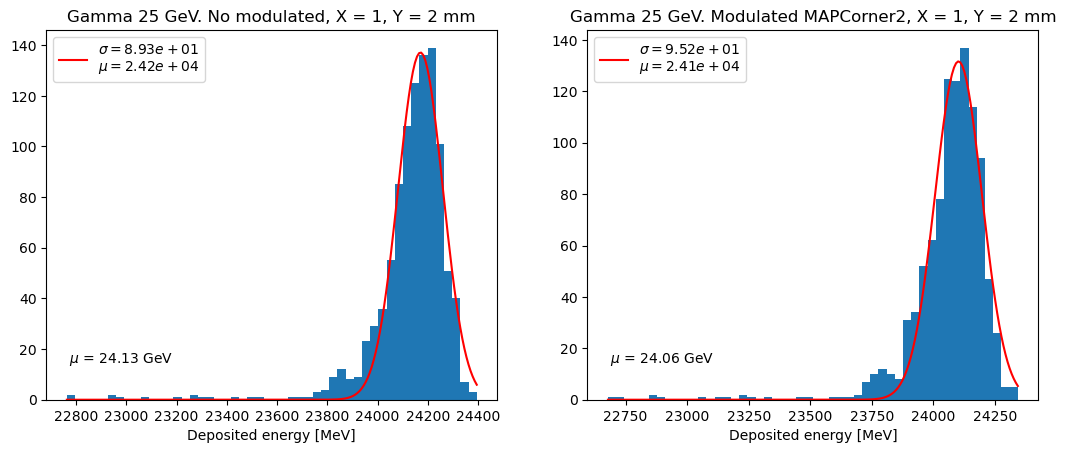

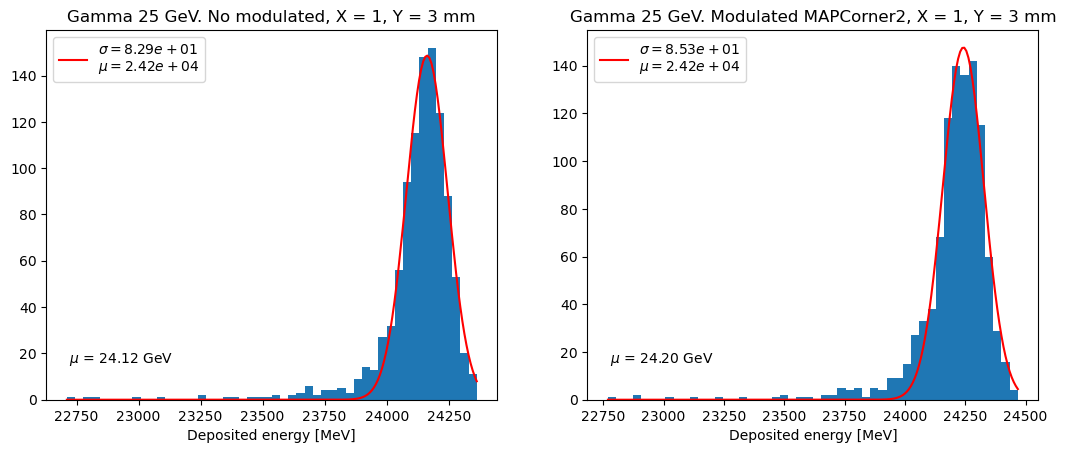

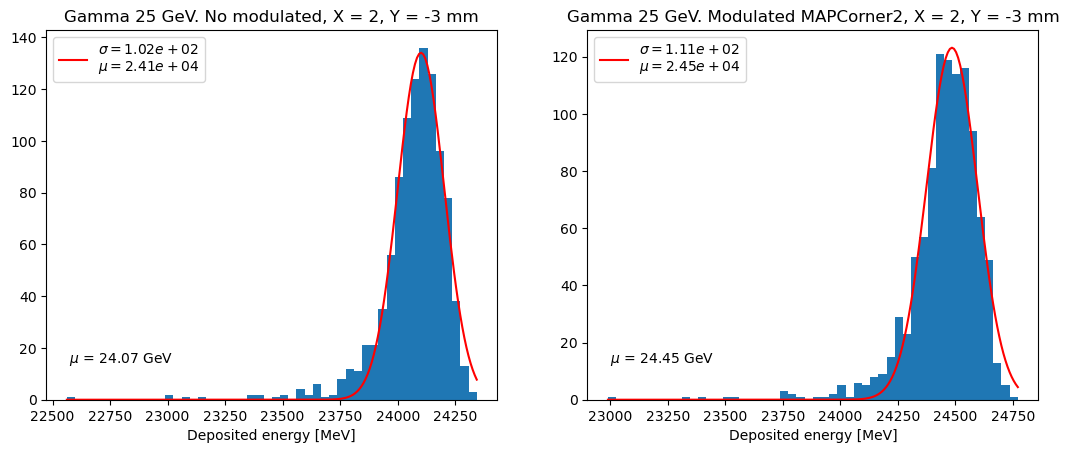

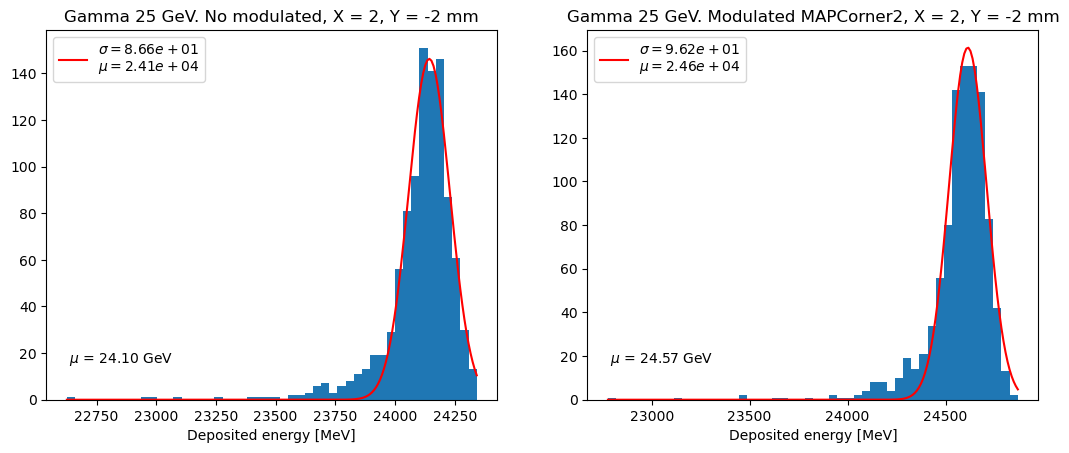

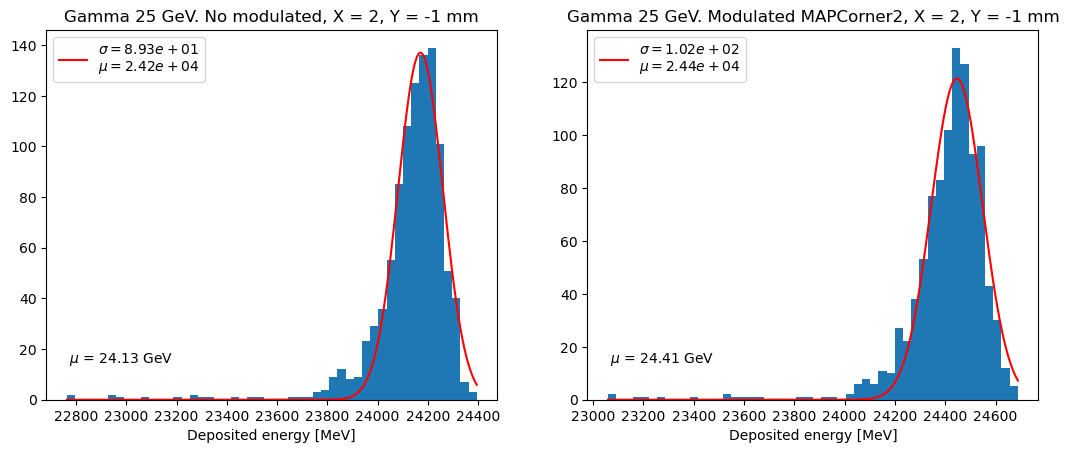

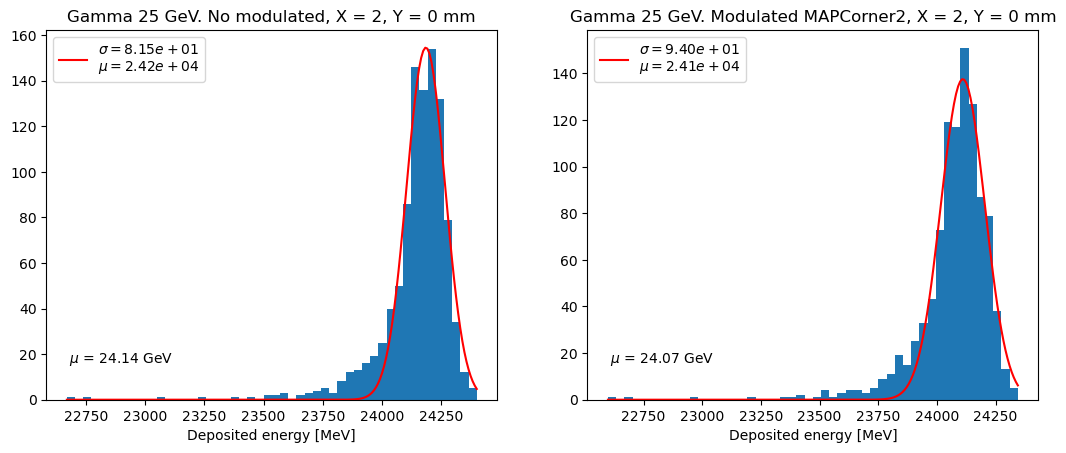

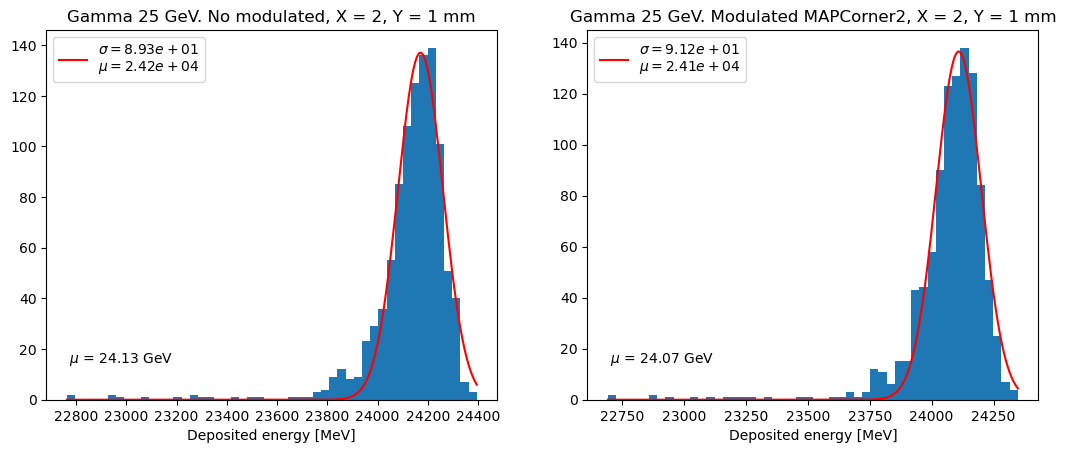

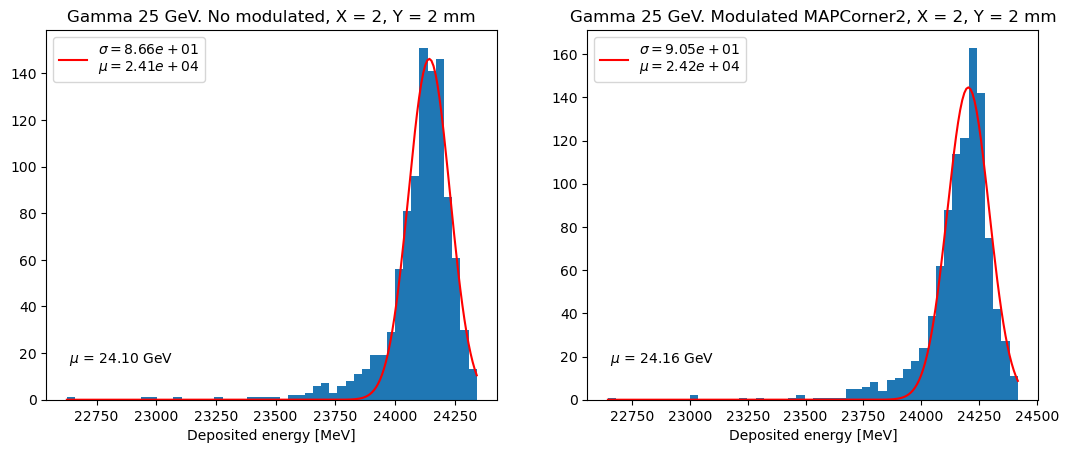

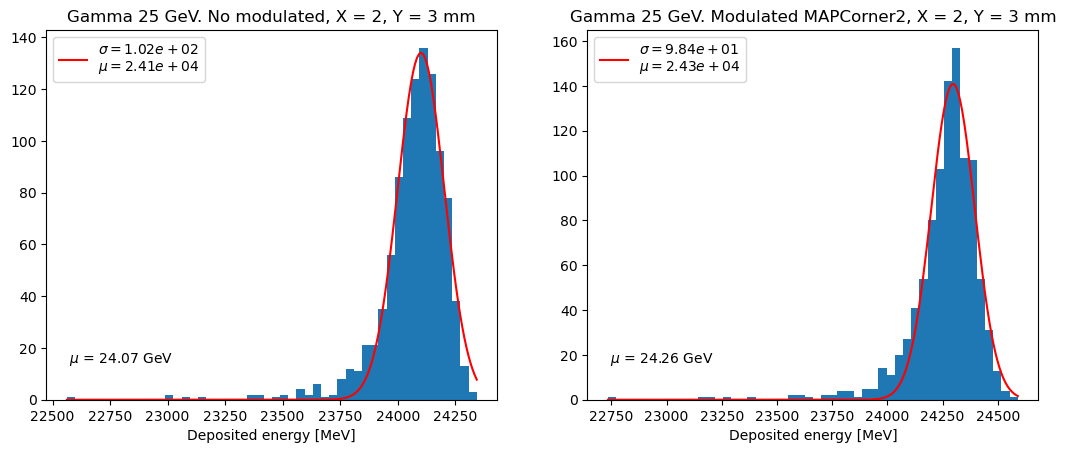

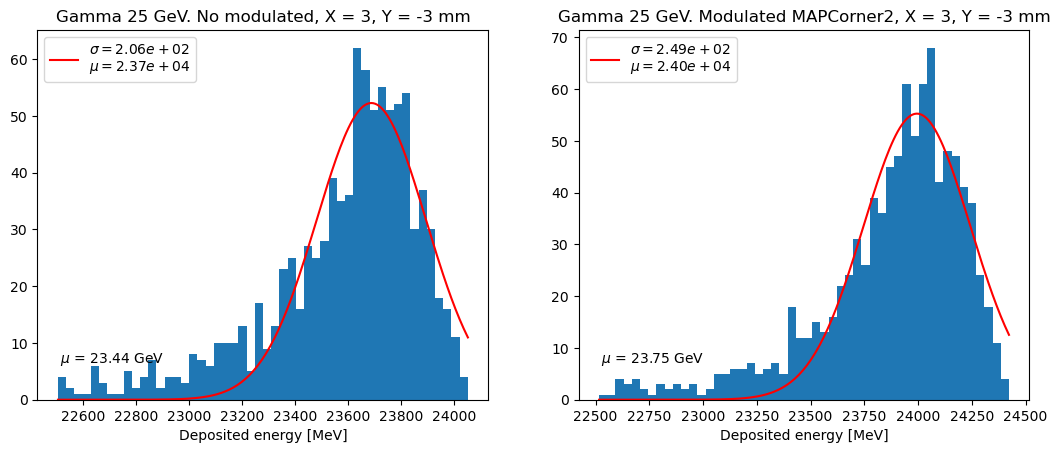

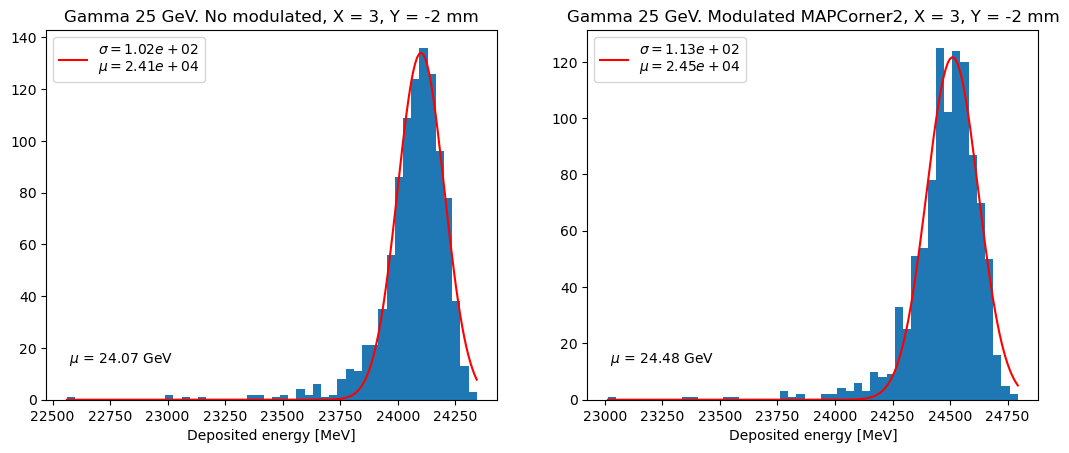

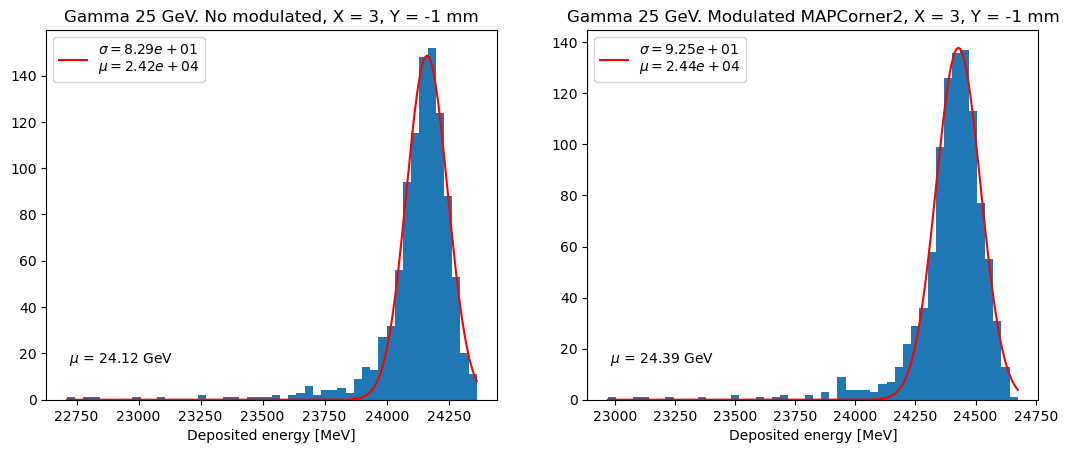

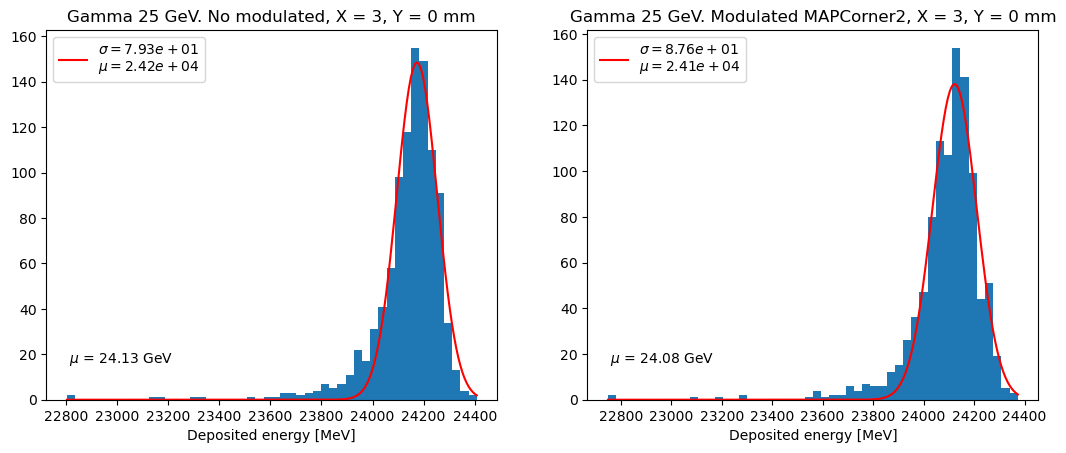

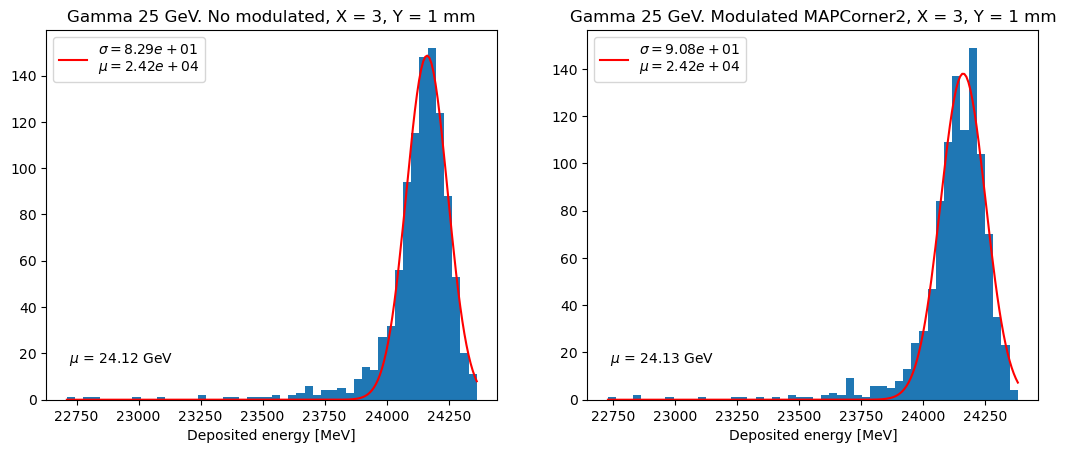

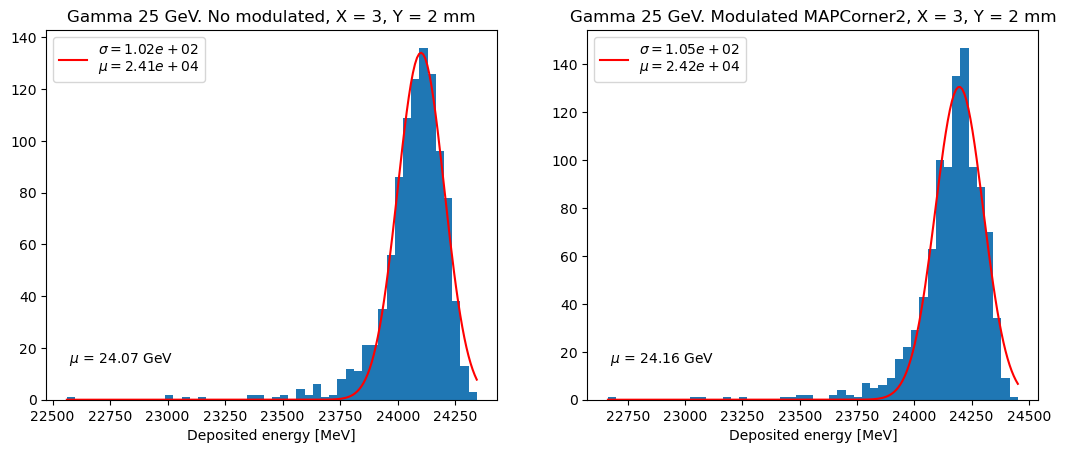

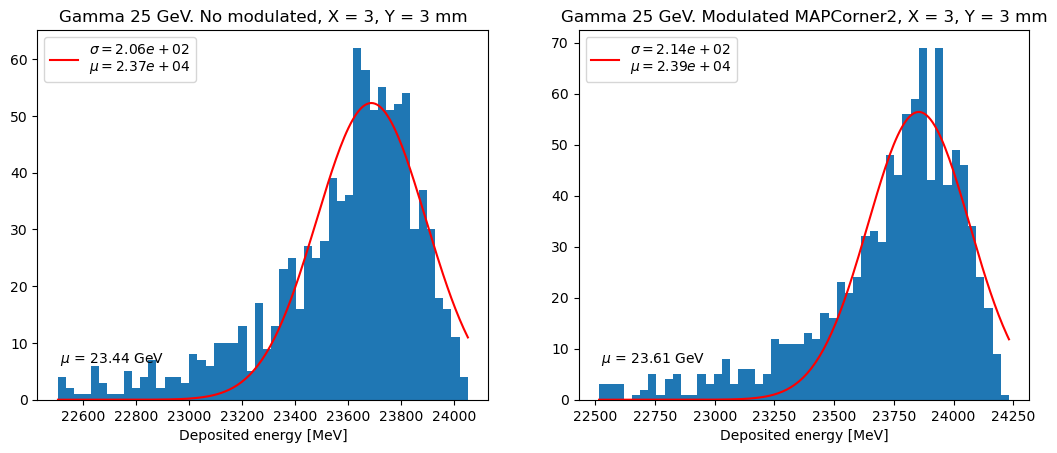

In [113]:
meanDetectedEdeps = {}
eDeps_modulated_dict = {}

def getMeshFromSymmetry(mesh, x, y):

    if np.abs(y) > np.abs(x):

        mesh = np.transpose(mesh, [0,2,1]) 

    if x < 0:
        mesh = mesh[:,::-1,:]

    if y < 0:
        mesh = mesh[:,:,::-1]

    return mesh


for i in range(7):
    for j in range(7):

        x = np.abs(i-3)
        y = np.abs(j-3)

        if y > x: x,y = y,x

        key = f"X={x},Y={y}"

        eDeps = meshs_dict[key]

        eDeps = getMeshFromSymmetry(eDeps, i-3, j-3)


        eDeps = np.sum(eDeps, axis=-1)
        eDeps = np.sum(eDeps, axis=-1)

        fig, (ax1, ax2) = plt.subplots(1,2,figsize=(2*6.4, 1*4.8))
        # ax1.hist(eDeps[eDeps > ENERGY*1000*ENERGY_PLOT_CUT], bins=40, label="$\mu = {:.4f}$ GeV".format( np.mean(eDeps)/1000 ))
        dispHistAndGauss(ax1, eDeps[eDeps > ENERGY*1000*ENERGY_PLOT_CUT])
        ax1.text(0.05, 0.1, "$\mu$ = {:.2f} GeV".format(np.mean(eDeps)/1000), transform=ax1.transAxes)

        ax1.set_title(f"Gamma {ENERGY} GeV. No modulated, X = {i-3}, Y = {j-3} mm")
        ax1.set_xlabel("Deposited energy [MeV]")
        ax1.legend()

        ####################################################################

        eDeps = meshs_dict[key]

        eDeps = getMeshFromSymmetry(eDeps, i-3, j-3)

        wights_map_exp_dim = np.expand_dims(wights_map, axis = 0)

        eDeps = eDeps*wights_map_exp_dim

        eDeps = np.sum(eDeps, axis=-1)
        eDeps = np.sum(eDeps, axis=-1)

        dispHistAndGauss(ax2, eDeps[eDeps > ENERGY*1000*ENERGY_PLOT_CUT])

        ax2.text(0.05, 0.1, "$\mu$ = {:.2f} GeV".format(np.mean(eDeps)/1000), transform=ax2.transAxes)

        ax2.set_title(f"Gamma {ENERGY} GeV. Modulated {MAP_NAME}, X = {i-3}, Y = {j-3} mm")
        ax2.set_xlabel("Deposited energy [MeV]")
        ax2.legend()

        keyFull = f"X={i-3},Y={j-3}"

        meanDetectedEdeps[keyFull] = np.mean(eDeps)/1000

        eDeps_modulated_dict[keyFull] = eDeps

        fig.savefig("plots/"+keyFull+".png")
        # plt.close()

In [114]:
efficiency_mesh = np.zeros( (7,7) )

eDep_uniform_source = np.array([])

for i in range(7):
    for j in range(7):

        x = i-3
        y = j-3

        key = f"X={x},Y={y}"

        efficiency_mesh[i][j] = meanDetectedEdeps[key]

        eDep_uniform_source = np.concatenate([eDep_uniform_source, eDeps_modulated_dict[key] ])

# efficiency_mesh /= np.mean(efficiency_mesh)

# # cast mesh to be in persent and substract 100% for better representation
# efficiency_mesh = (efficiency_mesh-1)*100

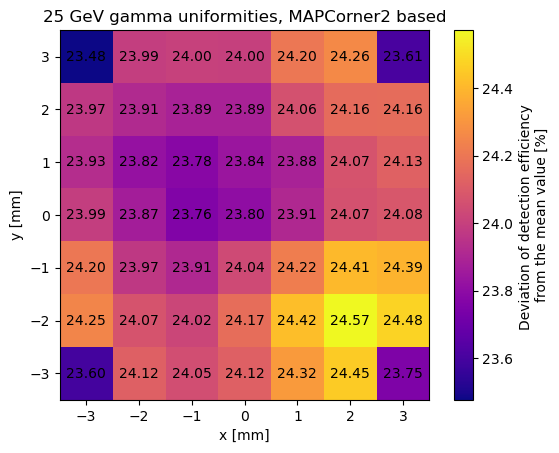

In [115]:
plt.figure(figsize=(6.4, 4.8))
plt.imshow(np.transpose(efficiency_mesh)[::-1,:], extent=(-3.5, 3.5, -3.5, 3.5))

np.savetxt(f"for_publication_efficiency_{MAP_NAME}_{ENERGY}GeV.txt", efficiency_mesh)

for (j,i),label in np.ndenumerate(np.transpose(efficiency_mesh)[::-1,:]):
    
    plt.gca().text(i-3,3-j,"{:.2f}".format(label),ha='center',va='center')

cbar = plt.colorbar()
cbar.ax.set_ylabel("Deviation of detection efficiency \nfrom the mean value [%]")

plt.title(f"{ENERGY} GeV gamma uniformities, {MAP_NAME} based")
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")

plt.savefig("plots/Efficiency_map_gammas.png")

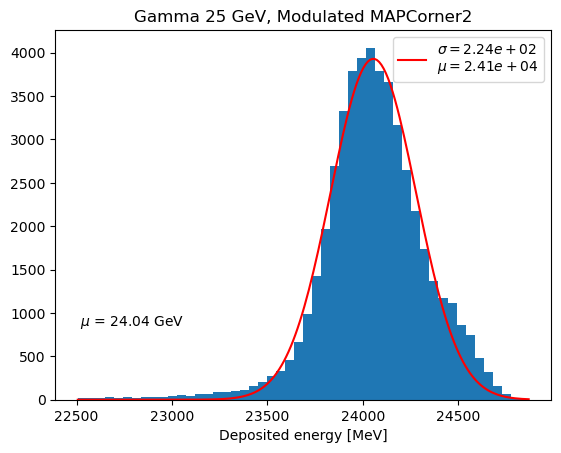

In [116]:
plt.figure()

ax = plt.gca()

dispHistAndGauss(ax, eDep_uniform_source[eDep_uniform_source > ENERGY*1000*ENERGY_PLOT_CUT])

np.savetxt("for_conference_eDep_uniform_source1.txt", eDep_uniform_source[eDep_uniform_source > ENERGY*1000*ENERGY_PLOT_CUT])

ax.text(0.05, 0.2, "$\mu$ = {:.2f} GeV".format(np.mean(eDep_uniform_source)/1000), transform=ax.transAxes)

ax.set_title(f"Gamma {ENERGY} GeV, Modulated {MAP_NAME}")
ax.set_xlabel("Deposited energy [MeV]")
ax.legend()

plt.savefig("plots/Entire_cell_resolution._Modulated_eDep.png")